In [152]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st


## Summary

This notebook tests the trigger and veto logic with internally-generated signals. The following tests are carried out. See the requirements document for more details.  The September 14 version of the firmware passes all the tests except that ethernet data capture does not work.

### Contents 
1. Functions and Setup
2. Initial test without delays
3. Use a snapshot to test that I'm writing delays to the correct antennas
4. Test that antenna roles are set to the correct channels
5. Simple tests of trigger and veto individually
6. Main tests-- see requirements document for discription of scenarios
7. Match simulink tests
8. Test readout over ethernet from internal trigger.


##### Here are some notes for building towards an observing setup script.
1. Set the delays with the setdelays function.
2. Set up the trigger and veto parameters with the setup_coincidencer function.
3. Do the ethernet setup and enabling.
4. Enable the coincidence trigger.
5. Remember to turn the coincidencer off before sending a pulse from software.


TO DO:


Internally-triggered ethernet readout is not yet tested. 

## Functions setup

In [153]:
def test_coincidencer(casperbrd,trigger_power_thresh,
                      veto_power_thresh,
                      trigger_window,
                      veto_window,
                      antenna_number_thresh,
                      veto_number_thresh,
                      delays,
                      core_roles_array,
                      veto_roles_array):

    setup_coincidencer(casperbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)
    set_delays(casperbrd,delays)

    # reset trigger counter
    setvalue(casperbrd,"trig_debug_reset","cr_registers.xlsx",1)
    time.sleep(0.003)
    setvalue(casperbrd,"trig_debug_reset","cr_registers.xlsx",0)
    internal_trigger_count1=getvalue(casperbrd,"internal_trigger_count","cr_registers.xlsx")

    time.sleep(2.75)  #have to wait for it to update
    trigger_count=getvalue(casperbrd,"count_triggers","cr_registers.xlsx")
    internal_trigger_count2=getvalue(casperbrd,"internal_trigger_count","cr_registers.xlsx")
    triggers_leaving_block=(internal_trigger_count2-internal_trigger_count1)
    veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
    #internal_triggers=struct.unpack('>2l',casperbrd.read("cosmic_ray_internal_trigger_rate",2*4,0)) #does not work.
    print("Core coincidence per 10b cycle: ", core_coincidence/262144.)
    print("Veto coincidence per 10b cycle: ", veto_coincidence/262144.)
    print("Triggers at state control ",trigger_count)
    #print("Triggers leaving coincidence_trigger block per cycle", internal_triggers) #bram counter doesn't work
    print("Triggers leaving block", triggers_leaving_block)

    return

In [154]:
#fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-09-02_1527.fpg'
#fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-09-13_2121.fpg'
fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-09-20_1316.fpg'
brdname='snap01'
brd=snap2_fengine.Snap2Fengine(brdname)
casperbrd = casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport)

2022-12-31 20:20:31,561 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-12-31 20:20:31,898 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [155]:
brd.program(fpgfile)


2022-12-31 20:20:36,629 - lwa_f.snap2_fengine:snap01 - INFO - Loading firmware /home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-09-20_1316.fpg to snap01


100% (600 of 600) |######################| Elapsed Time: 0:05:31 Time:  0:05:31


2022-12-31 20:26:30,519 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-12-31 20:26:30,754 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [156]:
casperbrd.listdev()
brd.initialize(read_only=False)
brd.sync.arm_sync()
brd.sync.sw_sync()

2022-12-31 20:55:54,337 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (writable): fpga
2022-12-31 20:55:54,338 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (writable): adc
2022-12-31 20:55:54,341 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 0: Setting clock source to 1
2022-12-31 20:55:54,348 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 1: Setting clock source to 1
2022-12-31 20:55:54,356 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 board 0: Setting clock source to 1
2022-12-31 20:55:54,364 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 board 1: Setting clock source to 1
2022-12-31 20:56:08,286 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 0 clock rates: [490713622, 98213758, 98285369, 0, 0]
2022-12-31 20:56:08,287 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 0: MMCM locked
2022-12-31 20:56:09,298 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 1 clock rates: [490658961, 98155253, 98223696, 98246529, 0]
2022-12-

100% (64 of 64) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


2022-12-31 20:56:24,555 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 data lane delays:
[[400, 392, 400, 384, 384, 384, 384, 384], [368, 352, 352, 344, 352, 352, 344, 344], [336, 336, 336, 336, 336, 336, 336, 344], [368, 384, 360, 360, 368, 368, 368, 360], [352, 344, 352, 352, 352, 352, 352, 344], [320, 328, 328, 328, 320, 320, 320, 320], [344, 320, 328, 328, 328, 344, 320, 328], [368, 368, 368, 360, 360, 368, 376, 360]]
2022-12-31 20:56:24,556 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 32, 32, 32, 32], [40, 40, 40, 40, 40, 40, 40, 32], [40, 40, 40, 40, 40, 32, 40, 32], [32, 32, 32, 32, 32, 32, 32, 32], [40, 40, 40, 32, 32, 40, 40, 32], [40, 40, 32, 40, 40, 40, 40, 40], [40, 32, 40, 32, 32, 32, 32, 40], [40, 40, 40, 32, 32, 32, 32, 32]]
2022-12-31 20:56:24,557 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXX
2022-12-31 20:56:24,558 - lwa_f.blocks.block:snap01 - INF

2022-12-31 20:56:24,593 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXX
2022-12-31 20:56:24,594 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXX
2022-12-31 20:56:24,594 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXX
2022-12-31 20:56:24,595 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXX
2022-12-31 20:56:24,596 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXX
2022-12-31 20:56:24,596 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXX
2022-12-31 20:56:24,597 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


2022-12-31 20:56:39,025 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 because everywhere was bad
2022-12-31 20:56:40,309 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


2022-12-31 20:56:48,716 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 because everywhere was bad
2022-12-31 20:56:49,848 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


2022-12-31 20:56:58,788 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-12-31 20:56:58,800 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-12-31 20:56:58,812 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-12-31 20:56:58,928 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-12-31 20:57:00,684 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


2022-12-31 20:57:11,581 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-12-31 20:57:11,595 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-12-31 20:57:11,609 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-12-31 20:57:11,624 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-12-31 20:57:12,731 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


2022-12-31 20:57:27,039 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-12-31 20:57:27,055 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-12-31 20:57:27,069 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-12-31 20:57:27,083 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-12-31 20:57:28,270 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


2022-12-31 20:57:36,796 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-12-31 20:57:36,811 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-12-31 20:57:36,824 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-12-31 20:57:36,837 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-12-31 20:57:37,867 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


2022-12-31 20:57:51,628 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-12-31 20:57:51,644 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-12-31 20:57:51,657 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-12-31 20:57:51,668 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-12-31 20:57:52,821 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


2022-12-31 20:58:04,099 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 data lane delays:
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [312, 312, 312, 320, 312, 312, 312, 312], [248, 248, 248, 240, 256, 240, 256, 240], [296, 288, 296, 304, 296, 280, 288, 296], [336, 328, 328, 328, 328, 328, 328, 320]]
2022-12-31 20:58:04,100 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 data lane slacks:
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [48, 40, 40, 40, 40, 40, 40, 40], [40, 32, 32, 32, 40, 32, 40, 32], [32, 32, 32, 32, 32, 32, 32, 32], [40, 32, 32, 40, 32, 32, 32, 32]]
2022-12-31 20:58:04,100 - lwa_f.blocks.block:snap01 - WARNING - adc - Delay solutions have small slack
2022-12-31 20:58:04,101 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 0, Lane 0:    |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-12-31 20:58:04,102 - lwa_f.blocks.block:snap0

2022-12-31 20:58:04,132 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 1:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXX
2022-12-31 20:58:04,133 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-12-31 20:58:04,134 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXX
2022-12-31 20:58:04,134 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-12-31 20:58:04,135 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXX
2022-12-31 20:58:04,135 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXX
2022-12-31 20:58:04,136 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 7:    XXXXXXXX

In [157]:
setup_data_source(casperbrd,"adc")  #set it to adc here, and then set the counter test signal BEFORE the cosmic ray block

Data source set to adc


In [158]:
print(casperbrd.read_int('set_counter_test_signal'))
casperbrd.write_int('set_counter_test_signal',1)
print(casperbrd.read_int('set_counter_test_signal'))

setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)


0
1


The data source is set to a counter, before the delay block. 
## Initial test without setting delays
The threshold is set to 511, all antennas have both roles, the antenna number thresholds and the window thresholds are zero.  As expected, all antennas reach the threshold once per 1024 clock cycles, and so there is a trigger and a veto once every 1024 clock cycles, or 262144 times in every time interval between updating the counter register.

In [159]:
#define parameters
trigger_power_thresh=511**2
veto_power_thresh=511**2
trigger_window=100
veto_window=200
antenna_number_thresh=0
veto_number_thresh=0

#see notebook subarray_threshold_scans for a function to extract the delays from a text file of delays and antenna names
delays=10*np.ones(64,dtype=int)
core_roles_array=np.ones(64,dtype=int)
veto_roles_array=np.ones(64,dtype=int)

setup_coincidencer(casperbrd,trigger_power_thresh,
                      veto_power_thresh,
                      trigger_window,
                      veto_window,
                      antenna_number_thresh,
                      veto_number_thresh,
                      core_roles_array,
                      veto_roles_array)
set_delays(casperbrd,delays)

time.sleep(2.75)  #have to wait for it to update.  The wait is this long because the current cycle will have a mix of settings. It has to finish.  Then the next cycle has to finish to get all good data.
veto_coincidence,core_coincidence=struct.unpack('>2l',casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
core,veto = read_threshold_rates(casperbrd) #read each block

print("Core coincidence: ", core_coincidence)
print("Veto coincidence: ", veto_coincidence)
print(core[0],veto[1])
print(min(core),max(core))
print(min(veto),max(veto))
clockcycles_counted_for=(2**28)  #number of clock cycles that the trigger and veto rate counters counts for before updating
number_of_10bit_counter_cycles=clockcycles_counted_for/1024 #number of times the 10 bit counter starts over during the above count
print("Clock cycles counted for ", clockcycles_counted_for)
print("Time counted for ", clockcycles_counted_for*5e-9)

print(number_of_10bit_counter_cycles)

Core coincidence:  262144
Veto coincidence:  262144
262144.0 262144.0
262144.0 262144.0
262144.0 262144.0
Clock cycles counted for  268435456
Time counted for  1.34217728
262144.0


In [160]:
#repeat above, in order to test out the test function
trigger_power_thresh=511**2
veto_power_thresh=511**2
trigger_window=100
veto_window=200
antenna_number_thresh=0
veto_number_thresh=0

test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


## 3. Use a snapshot to test that I'm writing delays to the correct antennas

I saved two snapshots, one after applying delays where the delays count up from 0 to 63 and the other where delays count down.  In a previous version, the snapshots show that the delays are applied as expected. Here, they are both counting up but since this passes all the other tests I need to confirm that it isn't part of a larger readout problem.

In [187]:
setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0)
delays=64-np.asarray(range(64))
set_delays(casperbrd,delays)

setup_ethernet(brdname,casperbrd,fpgfile,'lwacr',100)
setvalue(casperbrd,'brd_id','cr_registers.xlsx',1)

#enable ethernet
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)
#send trigger
software_trigger(casperbrd,1)

#set delays counting up
delays=np.asarray(range(64))
set_delays(casperbrd,delays)
software_trigger(casperbrd,1)


------------------------
snap01:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:01:01:01
Gateway:  0.0.0.1
IP:  10.41.0.201
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 58: MAC: 04:3F:72:DF:C2:F8
Setting wait between packets to 100
Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 22848 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0
Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 22848 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


Text(0, 0.5, 'value')

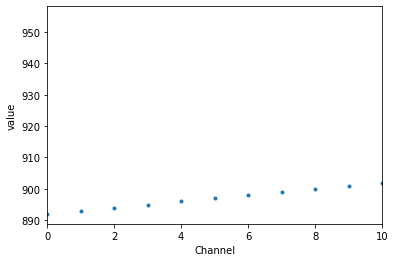

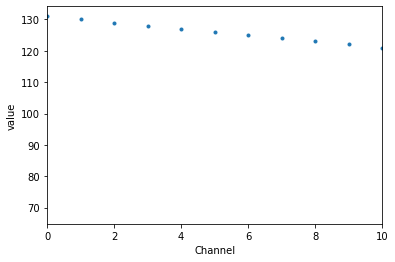

In [188]:
#old snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1662926949.397944_0_0.npy'
#snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1672524669.2956147_0_0.npy'
#snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1672525117.9031954_0_0.npy'
snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1672599026.9217265_0_0.npy'

snapshot=np.load(snapshotfname)

chanmap=np.loadtxt('channelmap.txt')
plt.figure()
timesample=2500
plt.plot(chanmap[1,:],snapshot[timesample,4:],'.')
plt.xlim(0,10)
plt.xlabel('Channel')
plt.ylabel('value')

#old snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1662929772.1028724_0_0.npy'
#snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1672524670.9214463_0_0.npy'
#snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1672525119.523457_0_0.npy'
snapshotfname='/home/ubuntu/kp/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1672599028.608758_0_0.npy'

snapshot=np.load(snapshotfname)

plt.figure()
timesample=2500
plt.plot(chanmap[1,:],snapshot[timesample,4:],'.')
plt.xlim(0,10)
plt.xlabel('Channel')
plt.ylabel('value')

In [162]:
#disable ethernet and enable internal trigger
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',0)

setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)


## Are the antenna roles being set to the correct channels?
In a previous version of this notebook I found that packantennaroles had the wrong bit order and I changed that. Here I'm testing whether the new version works. 

I'm testing the trigger and veto simultaneously with the same approach:  All the antennas are set to participate, and then one is turned off and delayed outside the window.  The threshold is set to 62. If the delayed antenna is not the turned-off antenna, there won't be enough antennas for a coincidence detected.

In [163]:
#initial setup
trigger_power_thresh=511**2
veto_power_thresh=511**2
core_roles_array=np.ones(64,dtype=int)
veto_roles_array=np.ones(64,dtype=int)

antenna_number_thresh=62
veto_number_thresh=62
veto_window=15
trigger_window=10
delays=np.zeros(64,dtype=int)


Test before turning one antenna off. There should be a coincidence and there is.


In [164]:
#test before turning one antenna off. There should be a coincidence
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)


Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


Turn one antenna off but don't delay it. There should still be a coincidence even if the antenna roles go to the wrong antennas, and there is.

In [165]:
core_roles_array=np.ones(64,dtype=int)
veto_roles_array=np.ones(64,dtype=int)
core_roles_array[0]=0
veto_roles_array[0]=0
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)


Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


Delay the turned-off antenna.  There's a coincidence.
Repeat for all the antennas.

In [166]:
for i in range(64):
    print("Testing Antenna " + str(i))
    core_roles_array=np.ones(64,dtype=int)
    veto_roles_array=np.ones(64,dtype=int)
    core_roles_array[i]=0
    veto_roles_array[i]=0
    delays=np.zeros(64,dtype=int)
    delays[i]=100
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)


Testing Antenna 0
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 1
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 2
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 3
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 4
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 5
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 6
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Tri

Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 57
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 58
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 59
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 60
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 61
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Testing Antenna 62
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leavin

In [167]:
triggerantennas1=getvalue(casperbrd,'trigger_antennas1','cr_registers.xlsx')
print(bin(triggerantennas1))
triggerantennas2=getvalue(casperbrd,'trigger_antennas2','cr_registers.xlsx')
print(bin(triggerantennas2))


vetoantennas1=getvalue(casperbrd,'veto_antennas1','cr_registers.xlsx')
print(bin(vetoantennas1))
vetoantennas2=getvalue(casperbrd,'veto_antennas2','cr_registers.xlsx')
print(bin(vetoantennas2))


0b11111111111111111111111111111111
0b11111111111111111111111111111110
0b11111111111111111111111111111111
0b11111111111111111111111111111110


The bit-order problem with the packantennaroles function appears to be resolved successfully.  

## Simple tests -- test trigger and veto individually

The expected output of the following cell is*:

Core coincidence per 10b cycle:  1.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  544611

Triggers leaving block 538585

Core coincidence per 10b cycle:  1.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  545631

Triggers leaving block 538397

Core coincidence per 10b cycle:  0.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  0

Triggers leaving block 0

Core coincidence per 10b cycle:  0.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  0

Triggers leaving block 0

Core coincidence per 10b cycle:  0.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  0

Triggers leaving block 0

*Trigger counts can vary slightly due to the time to read the register, coincidence counts should be exactly correct.

In [168]:
#no veto antennas used, only trigger
trigger_power_thresh=511**2
veto_power_thresh=511**2
core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:2]=1
veto_roles_array=np.zeros(64,dtype=int)
antenna_number_thresh=1
veto_number_thresh=0
veto_window=0

trigger_window=10
delays=np.zeros(64,dtype=int)
delays[0]=1
delays[1]=2 

test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[1]=8 
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[1]=11 
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[1]=12
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[1]=200
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)


Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  545073
Triggers leaving block 538682
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  545826
Triggers leaving block 539053
Core coincidence per 10b cycle:  0.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  0
Triggers leaving block 0
Core coincidence per 10b cycle:  0.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  0
Triggers leaving block 0
Core coincidence per 10b cycle:  0.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  0
Triggers leaving block 0


### Test the veto by itself. All these have a core trigger.
The expected output is*:

Core coincidence per 10b cycle:  1.0 

Veto coincidence per 10b cycle:  1.0

Triggers at state control  0

Triggers leaving block 0

Core coincidence per 10b cycle:  1.0

Veto coincidence per 10b cycle:  1.0

Triggers at state control  0

Triggers leaving block 0

Core coincidence per 10b cycle:  1.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  546062

Triggers leaving block 537924

Core coincidence per 10b cycle:  1.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  545295

Triggers leaving block 538346

Core coincidence per 10b cycle:  1.0

Veto coincidence per 10b cycle:  0.0

Triggers at state control  559426

Triggers leaving block 552852


*Trigger counts can vary slightly due to the time to read the register, coincidence counts should be exactly correct.

In [169]:
#test the veto by itself. All these have a core trigger.
trigger_power_thresh=511**2
veto_power_thresh=511**2
core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0]=1
core_roles_array[1]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[2]=1
veto_roles_array[3]=1

antenna_number_thresh=1
veto_number_thresh=1
veto_window=15
trigger_window=10
delays=np.zeros(64,dtype=int)
delays[0]=1
delays[1]=2 
delays[2]=1
delays[3]=2 

test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[3]=12
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[3]=16
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[3]=20
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)

delays[3]=100
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)


Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  545236
Triggers leaving block 539815
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  564442
Triggers leaving block 538366
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  0.0
Triggers at state control  582917
Triggers leaving block 538475


# Main Tests

Trigger and veto power thresholds remain 511, and the core and veto number thresholds remain 2 (at least three antennas required).  The core antennas are signals 0, 1, and 2, and the veto antennas are signals 3, 4, 5.  The next sections go through five scenarios with variants.






In [170]:

trigger_power_thresh=511**2
veto_power_thresh=511**2
core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:3]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[3:6]=1
antenna_number_thresh=2
veto_number_thresh=2



 If the veto requires Nv antennas and the core requires Nc antennas, then the veto cancels the core if $ |t_{nv} - t_{nc} -2| < W_v +1$ where $W_v$ is the veto window, $t_{nc}$ is the time that the $Nc^{th}$ core antenna receives the signal, and t_{nv} is the time that the $Nv^{th}$ veto antenna receives the signal. Note LESS than not less or equal.  The -2 and the +1 are due to relative clock cycle differences within the firmware logic (e.g. net affect of the latency of different blocks).

## Veto after Core
### a) Veto long after

In [171]:
delays=np.ones(64,dtype=int)
delays[0:6]=[1,5,10,450,500,508] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[11,11,100,100,300]
veto_windows=[510,500,500,503,500]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


print("2) Expect Veto misses trigger")
trigger_windows=[11,11,100,300,300]
veto_windows=[62,499,499,499,350]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

print("3) Expect No trigger or veto")
trigger_windows=[9,9,2]
veto_windows=[58,55,49]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


1) Expect Trigger is vetoed
trigger window:  11 veto window:  510
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  11 veto window:  500
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  500
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  503
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  500
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


2) Expect Veto misses trigger
trigger window:  11 veto window:  62
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycl

### b) Veto Soon after

In [173]:
delays=np.ones(64,dtype=int)
delays[0:6]=[1,5,9,20,50,55] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[10,10,100,100,300]
veto_windows=[48,503,48,503,450]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


print("2) Expect Veto misses trigger")
trigger_windows=[11,11,40,11,30]
veto_windows=[47,36,47,44,36]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

print("3) Expect No trigger or veto")
trigger_windows=[8,8,2]
veto_windows=[34,20,35]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


1) Expect Trigger is vetoed
trigger window:  10 veto window:  48
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  10 veto window:  503
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  48
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  503
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  450
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


2) Expect Veto misses trigger
trigger window:  11 veto window:  47
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:

### c) Veto widely arranged
The scenario where the veto misses the trigger isn't possible here because the minimum window to have a trigger is longer than the minimum window for the veto to cancel the core.

In [174]:
delays=np.ones(64,dtype=int)
delays[0:6]=[1,5,10,20,300,508] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[11,11,100,100,300]
veto_windows=[501,500,500,501,500]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


print("2) Expect Veto misses trigger")
trigger_windows=[11,11,40,11,30]
veto_windows=[499,498,499,490,496]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

print("3) Expect No trigger or veto")
trigger_windows=[9,9,2]
veto_windows=[488,483,20]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

1) Expect Trigger is vetoed
trigger window:  11 veto window:  501
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  11 veto window:  500
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  500
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  501
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  500
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


2) Expect Veto misses trigger
trigger window:  11 veto window:  499
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cyc

## 2. Veto before core

### a) Veto long before


In [175]:
delays=np.ones(64,dtype=int)
delays[0:6]=[508,498,490,1,7,10] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[20,20,100,100,300]
veto_windows=[495,496,495,499,495]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


print("2) Expect Veto misses trigger")
trigger_windows=[20,21,40,38,30]
veto_windows=[494,477,494,475,478]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

print("3) Expect No trigger or veto")
trigger_windows=[9,9,2]
veto_windows=[9,8,9]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

1) Expect Trigger is vetoed
trigger window:  20 veto window:  495
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  20 veto window:  496
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  495
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  499
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  495
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


2) Expect Veto misses trigger
trigger window:  20 veto window:  494
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cyc

### b) Veto soon before

In [176]:
delays=np.ones(64,dtype=int)
delays[0:6]=[501,498,490,488,480,482] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[12,12,100,100,300]
veto_windows=[10,480,18,10,300]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


print("2) Expect Veto misses trigger")
trigger_windows=[12,13,40,20,30]
veto_windows=[9,9,9,9,9]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

print("3) Expect No trigger or veto")
trigger_windows=[2,1,1]
veto_windows=[6,5,6]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

1) Expect Trigger is vetoed
trigger window:  12 veto window:  10
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  12 veto window:  480
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  18
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  10
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  300
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


2) Expect Veto misses trigger
trigger window:  12 veto window:  9
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  

### c) Veto widely arranged

In [177]:
delays=np.ones(64,dtype=int)
delays[0:6]=[508,498,490,488,200,10] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[19,19,100,100,300]
veto_windows=[479,480,479,500,501]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')



print("3) Expect No trigger or veto")
trigger_windows=[2,1,1]
veto_windows=[6,5,6]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

1) Expect Trigger is vetoed
trigger window:  19 veto window:  479
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  19 veto window:  480
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  479
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  500
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  501
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


3) Expect No trigger or veto
trigger window:  2 veto window:  6
Core coincidence per 10b cycle:  0.0
Veto coincidence per 10b cycle: 

## 3. Veto antennas on either side of core
The remaining scenarios don't include having the veto miss the core because the minimum window for the veto to occur usually is longer than the window for the veto to catch the core.

In [178]:
delays=np.ones(64,dtype=int)
delays[0:6]=[250,252,255,249,490,500] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[6,12,100,100,300]
veto_windows=[253,480,253,265,300]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')



print("3) Expect No trigger or veto")
trigger_windows=[2,1,1]
veto_windows=[251,5,251]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

1) Expect Trigger is vetoed
trigger window:  6 veto window:  253
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  12 veto window:  480
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  253
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  265
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  300
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


3) Expect No trigger or veto
trigger window:  2 veto window:  251
Core coincidence per 10b cycle:  0.0
Veto coincidence per 10b cycle:

## 4. Veto antennas on either side and among core

In [180]:
delays=np.ones(64,dtype=int)
delays[0:6]=[250,252,255,249,253,500] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[6,12,100,100,300]
veto_windows=[253,480,253,265,300]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')


print("3) Expect No trigger or veto")
trigger_windows=[2,1,1]
veto_windows=[251,5,251]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

1) Expect Trigger is vetoed
trigger window:  6 veto window:  253
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  12 veto window:  480
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  253
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  265
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  300
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


3) Expect No trigger or veto
trigger window:  2 veto window:  251
Core coincidence per 10b cycle:  0.0
Veto coincidence per 10b cycle:

## 5. Veto antennas among core
Again, having a veto miss the core isn't possible.

In [182]:
delays=np.ones(64,dtype=int)
delays[0:6]=[10,15,30,29,29,50] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)


print("1) Expect Trigger is vetoed")
trigger_windows=[21,22,100,100,300]
veto_windows=[22,480,22,265,22]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')



print("2) Expect Trigger and no veto")
trigger_windows=[21,22,100,150,300]
veto_windows=[21,21,21,21,21]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')



print("3) Expect No trigger or veto")
trigger_windows=[2,1,1]
veto_windows=[19,5,19]
for i in range(len(trigger_windows)):
    trigger_window=trigger_windows[i]
    veto_window=veto_windows[i]
    print("trigger window: ", trigger_window, "veto window: ", veto_window)
    test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
    print('')
print('')

1) Expect Trigger is vetoed
trigger window:  21 veto window:  22
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  22 veto window:  480
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  22
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  100 veto window:  265
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0

trigger window:  300 veto window:  22
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 0


2) Expect Trigger and no veto
trigger window:  21 veto window:  21
Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle: 

## Match the Simulink tests
Repeating all the tests in the August 23 Evernote note, but with the real system instead of Simulink.

A couple modifications to make an analogous test work with the 10 bit counter as signal:

--Voltage thresholds are always 511.
--Delays are 100,110,115,117,120 instead of 1000,1010,1015,1017,1020



In [188]:
'''delays=np.ones(64,dtype=int)
delays[0:5]=[100,110,115,117,120] #core antennas are first three, veto antennas are second three
trigger_power_thresh=511**2
veto_power_thresh=511**2'''

'delays=np.ones(64,dtype=int)\ndelays[0:5]=[100,110,115,117,120] #core antennas are first three, veto antennas are second three\ntrigger_power_thresh=511**2\nveto_power_thresh=511**2'

### Test A

In [190]:
'''
core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:2]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[2:5]=1
antenna_number_thresh=0
veto_number_thresh=0
trigger_window=20
veto_window=7
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
'''

'\ncore_roles_array=np.zeros(64,dtype=int)\ncore_roles_array[0:2]=1\nveto_roles_array=np.zeros(64,dtype=int)\nveto_roles_array[2:5]=1\nantenna_number_thresh=0\nveto_number_thresh=0\ntrigger_window=20\nveto_window=7\ntest_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)\n'

Result:  There was a core and veto coincidence, matching the simulation, however there is no final trigger.

### Test B

In [191]:
'''core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:2]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[2:5]=1
antenna_number_thresh=0
veto_number_thresh=0
trigger_window=7
veto_window=20
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
'''

'core_roles_array=np.zeros(64,dtype=int)\ncore_roles_array[0:2]=1\nveto_roles_array=np.zeros(64,dtype=int)\nveto_roles_array[2:5]=1\nantenna_number_thresh=0\nveto_number_thresh=0\ntrigger_window=7\nveto_window=20\ntest_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)\n'

Result:  Core and Veto both had a coincidence, with no final trigger, as expected and matching simulation.

### Test C

In [192]:
'''core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:2]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[2:5]=1
antenna_number_thresh=1
veto_number_thresh=1
trigger_window=11
veto_window=20
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
'''

'core_roles_array=np.zeros(64,dtype=int)\ncore_roles_array[0:2]=1\nveto_roles_array=np.zeros(64,dtype=int)\nveto_roles_array[2:5]=1\nantenna_number_thresh=1\nveto_number_thresh=1\ntrigger_window=11\nveto_window=20\ntest_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)\n'

Result:  Core and Veto both had a coincidence, with no final trigger, as expected and matching simulation.

### Test D

In [193]:
'''core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:2]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[2:5]=1
antenna_number_thresh=1
veto_number_thresh=1
trigger_window=11
veto_window=12
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
'''

'core_roles_array=np.zeros(64,dtype=int)\ncore_roles_array[0:2]=1\nveto_roles_array=np.zeros(64,dtype=int)\nveto_roles_array[2:5]=1\nantenna_number_thresh=1\nveto_number_thresh=1\ntrigger_window=11\nveto_window=12\ntest_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)\n'

Result:  Core and Veto both had a coincidence, with no final trigger, as expected and matching simulation.

### Test E

In [194]:
'''core_roles_array=np.zeros(64,dtype=int)
core_roles_array[2:5]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[0:2]=1
antenna_number_thresh=1
veto_number_thresh=1
trigger_window=11
veto_window=12
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
'''

'core_roles_array=np.zeros(64,dtype=int)\ncore_roles_array[2:5]=1\nveto_roles_array=np.zeros(64,dtype=int)\nveto_roles_array[0:2]=1\nantenna_number_thresh=1\nveto_number_thresh=1\ntrigger_window=11\nveto_window=12\ntest_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)\n'

Result:  Core and Veto both had a coincidence, with no final trigger, but the simulation did have a final trigger.

### Is there a trigger when I turn off the veto?

In [195]:
'''core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:3]=1
veto_roles_array=np.zeros(64,dtype=int)
trigger_window=11
veto_window=100
test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
'''

'core_roles_array=np.zeros(64,dtype=int)\ncore_roles_array[0:3]=1\nveto_roles_array=np.zeros(64,dtype=int)\ntrigger_window=11\nveto_window=100\ntest_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)\n'

## More NOtes
Antenna number thresholds are greater than. If 3 is set to the register, then four antennas are the minimum for a trigger.

## Make sure the internal trigger can cause a snapshot to be sent over ethernet
There is now a separate notebook for this

In [148]:
'''#disable trigger before setting up ethernet
setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",0)
setup_ethernet(brdname,casperbrd,fpgfile,'lwacr',1000)
#enable ethernet
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)


software_trigger(casperbrd,1)
'''

------------------------
snap01:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:01:01:01
Gateway:  0.0.0.1
IP:  10.41.0.201
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 58: MAC: 04:3F:72:DF:C2:F8
Setting wait between packets to 1000
Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 80448 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


In [ ]:
'''#enable trigger 
#setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)'''

In [146]:
'''#set up a scenario where there should be triggers
delays=np.ones(64,dtype=int)
delays[0:6]=[1,5,10,20,300,508] #core antennas are first three, veto antennas are second three
set_delays(casperbrd,delays)

trigger_power_thresh=511**2
veto_power_thresh=511**2
core_roles_array=np.zeros(64,dtype=int)
core_roles_array[0:3]=1
veto_roles_array=np.zeros(64,dtype=int)
veto_roles_array[3:6]=1
antenna_number_thresh=2
veto_number_thresh=2
trigger_window=11
veto_window=499

test_coincidencer(casperbrd,trigger_power_thresh,veto_power_thresh,trigger_window,veto_window,antenna_number_thresh,veto_number_thresh,delays,core_roles_array,veto_roles_array)
'''

Core coincidence per 10b cycle:  1.0
Veto coincidence per 10b cycle:  1.0
Triggers at state control  0
Triggers leaving block 537982


In [ ]:
'''setvalue(casperbrd,"enable_coinc_trig","cr_registers.xlsx",1)
'''

In [149]:
'''setvalue(casperbrd,'eth_enable','cr_registers.xlsx',0)
'''